<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import seaborn as sb
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn import preprocessing
import timeit

#pd.set_option('display.max_rows', 500)
#pd.set_option('display.max_columns', None)

In [2]:
# # Load data
df_train = pd.read_parquet('../data/training_set.parquet', engine = 'auto')
#df_train = df_train[df_train['srch_id'] < 10000]
df_test = pd.read_parquet('../data/test_set.parquet', engine = 'auto')

<h1>Data prep<h1\>

In [3]:
def make_score(row):
    if row['booking_bool'] == 1:
        return 5
    elif row['click_bool'] == 1:
        return 1
    return 0

# Add features for hour, day and month.
def date_time(df):
    df['date_time'] = pd.to_datetime(df['date_time'])
    df['hour'] = df['date_time'].dt.hour
    df['day'] = df['date_time'].dt.day
    df['month'] = df['date_time'].dt.month
    df = df.drop('date_time', axis=1)
    return df

def remove_cols(df, cols):
    return df.drop(cols, axis=1)

def remove_cols_nan(df, limit):
    for col in df.columns:
        if len(df[col]) * limit < df[col].isna().sum():
            df = df.drop(col, axis=1)
    return df

# Add column with a ranking for each property in a search based on another column.
def create_rank_feature(df, col):
    df['rank_' + str(col)] = df.groupby('srch_id')[col].rank(ascending=False)
    return df

# location score 2 has missing values for property on some rows while some rows have a score.
# take average of rows that do have a score. reduces nans from 1090348 to 182213.
def fill_location_score_2(df):
    df['prop_location_score2'] = df.groupby('prop_id')['prop_location_score2'].transform(lambda x: x.fillna(x.mean()))
    return df

# adds a normalised version of a column based on a chosen grouping.
def add_normalized_column(df, col, group):
    df['norm_' + str(col) + "_" + str(group)] = (
        (df[col] - df.groupby(group)[col].transform('mean')) 
        / df.groupby(group)[col].transform('std')
    )
    return df

def prep_data(df, target_cols, test=False):
    df_new = df.copy()
    if not test:
        print('add score')
        df_new['score'] = df_new.apply(lambda row: make_score(row), axis=1)
        df_new = df_new.drop(target_cols, axis=1)
        
    print('add hour, day, month')
    df_new = date_time(df_new)
    #df_new = remove_cols_nan(df_new, 0.9)
    
    # difference features
    print('add difference features')
    df_new['usd_diff'] = abs(df_new['visitor_hist_adr_usd'] - df_new['price_usd'])
    df_new['star_diff'] = abs(df_new['visitor_hist_starrating'] - df_new['prop_starrating'])
    
    
    # ranking features
    print('add rank features')
    df_new = create_rank_feature(df_new, 'price_usd')
    df_new = create_rank_feature(df_new, 'prop_starrating')
    df_new = create_rank_feature(df_new, 'prop_review_score')
    df_new = create_rank_feature(df_new, 'prop_location_score1')
    df_new = create_rank_feature(df_new, 'prop_location_score2')
    
    print("fill ls2")
    df_new = fill_location_score_2(df_new)
    
    print("remove nan")
    for i in df_new.columns[df_new.isnull().any(axis=0)]:
        df_new[i].fillna(-1,inplace=True)
    
    print('add normalised features')
    groups = ['srch_id', 'prop_country_id', 'srch_destination_id', 'srch_length_of_stay', 'srch_booking_window']
    targets = ['price_usd', 'prop_starrating', 'prop_review_score', 'prop_location_score1', 'prop_location_score2']
    for group in groups:
        for target in targets:
            df_new = add_normalized_column(df_new, target, group)
   
    df_new = add_normalized_column(df_new, 'price_usd', 'prop_id')
    
    print("remove nan\n")
    for i in df_new.columns[df_new.isnull().any(axis=0)]:
        df_new[i].fillna(0,inplace=True)
        
    for c in categorical_features:
        df_new[c] = df_new[c].astype('category')
    
    return df_new

In [4]:
target_cols = ['click_bool', 'booking_bool', 'gross_bookings_usd', 'position']
#df_new["norm_" + str(group) + str(col)] = df.groupby(group).col(df.col-g.transform('min')) / g.transform(np.ptp)
categorical_features = ['hour', 'day', 'month', 'srch_id', 'site_id', 'visitor_location_country_id', 'prop_country_id', 'prop_id', 'srch_destination_id', 'srch_room_count', 'srch_booking_window']

print("Prepping training data")
df_train = prep_data(df_train, target_cols, False)
print("Prepping test data")
df_test = prep_data(df_test, target_cols, True)

Prepping training data
add score
add hour, day, month
add difference features
add rank features
fill ls2
remove nan
add normalised features
remove nan

Prepping test data
add hour, day, month
add difference features
add rank features
fill ls2
remove nan
add normalised features
remove nan



<h1>Data split<h1\>

In [6]:
from sklearn.model_selection import GroupShuffleSplit

splitter = GroupShuffleSplit(test_size=0.2, n_splits=2, random_state = 7)
split = splitter.split(df_train, groups=df_train['srch_id'])
train_inds, test_inds = next(split)

df_ideal = df_train.iloc[test_inds].copy().sort_values(by=['srch_id', 'score'], ascending=[True, False], inplace=False)

X = df_train.drop(['score'], axis=1)
y = df_train['score']

X_train, X_test, y_train, y_test, test_ideal = X.iloc[train_inds], X.iloc[test_inds], y.iloc[train_inds], y.iloc[test_inds], df_ideal

train_groups = X_train.groupby('srch_id').size().to_frame('size')['size'].to_numpy()

test_groups = X_test.groupby('srch_id').size().to_frame('size')['size'].to_numpy()


<h1>Training <h1\>

In [7]:
params = {
    "objective": "lambdarank",
    "boosting_type":"dart",
    "metric":"ndcg",
    'n_estimators': 500, 
    'num_leaves': 180,
    'max_depth': 10, 
    'learning_rate': 0.08925380432712779, 
    'subsample': 0.523890758165789, 
    'colsample_bytree': 0.5433556425106324, 
    'feature_fraction': 0.9677058301342538,
    'reg_alpha': 0.00011669441178850782, 
    'reg_lambda': 0.008250891056480582
}

gbm = lgb.LGBMRanker(**params)


In [8]:
#categorical_feature = [df_train.columns.get_loc(c) for c in categorical_features if c in df_train]
gbm.fit(X_train, 
        y_train, 
        group=train_groups, 
        eval_set=[(X_test, y_test)], 
        eval_group=[test_groups],
        feature_name='auto', 
        categorical_feature = 'auto')






[LightGBM] [Warning] feature_fraction is set=0.9677058301342538, colsample_bytree=0.5433556425106324 will be ignored. Current value: feature_fraction=0.9677058301342538


/Users/hrvanelderen/anaconda3/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/hrvanelderen/anaconda3/lib/python3.10/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	valid_0's ndcg@1: 0.828784	valid_0's ndcg@2: 0.842155	valid_0's ndcg@3: 0.850917	valid_0's ndcg@4: 0.857305	valid_0's ndcg@5: 0.862399
[2]	valid_0's ndcg@1: 0.833472	valid_0's ndcg@2: 0.847379	valid_0's ndcg@3: 0.856498	valid_0's ndcg@4: 0.863017	valid_0's ndcg@5: 0.8679
[3]	valid_0's ndcg@1: 0.83483	valid_0's ndcg@2: 0.84888	valid_0's ndcg@3: 0.857973	valid_0's ndcg@4: 0.864543	valid_0's ndcg@5: 0.869584
[4]	valid_0's ndcg@1: 0.836141	valid_0's ndcg@2: 0.850462	valid_0's ndcg@3: 0.85965	valid_0's ndcg@4: 0.866314	valid_0's ndcg@5: 0.871123
[5]	valid_0's ndcg@1: 0.836539	valid_0's ndcg@2: 0.850988	valid_0's ndcg@3: 0.860161	valid_0's ndcg@4: 0.866853	valid_0's ndcg@5: 0.871701
[6]	valid_0's ndcg@1: 0.837024	valid_0's ndcg@2: 0.85174	valid_0's ndcg@3: 0.861041	valid_0's ndcg@4: 0.867574	valid_0's ndcg@5: 0.872549
[7]	valid_0's ndcg@1: 0.83753	valid_0's ndcg@2: 0.852231	valid_0's ndcg@3: 0.861559	valid_0's ndcg@4: 0.868273	valid_0's ndcg@5: 0.87321
[8]	valid_0's ndcg@1: 0.837604	vali

[60]	valid_0's ndcg@1: 0.840678	valid_0's ndcg@2: 0.856001	valid_0's ndcg@3: 0.865633	valid_0's ndcg@4: 0.87213	valid_0's ndcg@5: 0.877048
[61]	valid_0's ndcg@1: 0.840673	valid_0's ndcg@2: 0.85598	valid_0's ndcg@3: 0.865644	valid_0's ndcg@4: 0.872178	valid_0's ndcg@5: 0.877053
[62]	valid_0's ndcg@1: 0.840549	valid_0's ndcg@2: 0.855929	valid_0's ndcg@3: 0.865513	valid_0's ndcg@4: 0.872115	valid_0's ndcg@5: 0.877024
[63]	valid_0's ndcg@1: 0.84067	valid_0's ndcg@2: 0.855889	valid_0's ndcg@3: 0.86554	valid_0's ndcg@4: 0.872174	valid_0's ndcg@5: 0.877061
[64]	valid_0's ndcg@1: 0.840644	valid_0's ndcg@2: 0.855863	valid_0's ndcg@3: 0.86552	valid_0's ndcg@4: 0.872119	valid_0's ndcg@5: 0.877094
[65]	valid_0's ndcg@1: 0.840689	valid_0's ndcg@2: 0.855921	valid_0's ndcg@3: 0.865544	valid_0's ndcg@4: 0.872155	valid_0's ndcg@5: 0.877068
[66]	valid_0's ndcg@1: 0.840538	valid_0's ndcg@2: 0.855958	valid_0's ndcg@3: 0.865521	valid_0's ndcg@4: 0.872089	valid_0's ndcg@5: 0.87706
[67]	valid_0's ndcg@1: 0.8

[119]	valid_0's ndcg@1: 0.840798	valid_0's ndcg@2: 0.856536	valid_0's ndcg@3: 0.866006	valid_0's ndcg@4: 0.872461	valid_0's ndcg@5: 0.877374
[120]	valid_0's ndcg@1: 0.840728	valid_0's ndcg@2: 0.856463	valid_0's ndcg@3: 0.865997	valid_0's ndcg@4: 0.872433	valid_0's ndcg@5: 0.877335
[121]	valid_0's ndcg@1: 0.840838	valid_0's ndcg@2: 0.856529	valid_0's ndcg@3: 0.866071	valid_0's ndcg@4: 0.872451	valid_0's ndcg@5: 0.877408
[122]	valid_0's ndcg@1: 0.840788	valid_0's ndcg@2: 0.856547	valid_0's ndcg@3: 0.866063	valid_0's ndcg@4: 0.872462	valid_0's ndcg@5: 0.877397
[123]	valid_0's ndcg@1: 0.840798	valid_0's ndcg@2: 0.856526	valid_0's ndcg@3: 0.866079	valid_0's ndcg@4: 0.87252	valid_0's ndcg@5: 0.877423
[124]	valid_0's ndcg@1: 0.840833	valid_0's ndcg@2: 0.856528	valid_0's ndcg@3: 0.866142	valid_0's ndcg@4: 0.872554	valid_0's ndcg@5: 0.877424
[125]	valid_0's ndcg@1: 0.840854	valid_0's ndcg@2: 0.856596	valid_0's ndcg@3: 0.866081	valid_0's ndcg@4: 0.872567	valid_0's ndcg@5: 0.877443
[126]	valid_0'

[178]	valid_0's ndcg@1: 0.841059	valid_0's ndcg@2: 0.85664	valid_0's ndcg@3: 0.866238	valid_0's ndcg@4: 0.872778	valid_0's ndcg@5: 0.877806
[179]	valid_0's ndcg@1: 0.841114	valid_0's ndcg@2: 0.856725	valid_0's ndcg@3: 0.866286	valid_0's ndcg@4: 0.872777	valid_0's ndcg@5: 0.877801
[180]	valid_0's ndcg@1: 0.841099	valid_0's ndcg@2: 0.856726	valid_0's ndcg@3: 0.866289	valid_0's ndcg@4: 0.872766	valid_0's ndcg@5: 0.877795
[181]	valid_0's ndcg@1: 0.841029	valid_0's ndcg@2: 0.856661	valid_0's ndcg@3: 0.866256	valid_0's ndcg@4: 0.872746	valid_0's ndcg@5: 0.877747
[182]	valid_0's ndcg@1: 0.841029	valid_0's ndcg@2: 0.856708	valid_0's ndcg@3: 0.866245	valid_0's ndcg@4: 0.872755	valid_0's ndcg@5: 0.877769
[183]	valid_0's ndcg@1: 0.841094	valid_0's ndcg@2: 0.856645	valid_0's ndcg@3: 0.866218	valid_0's ndcg@4: 0.872736	valid_0's ndcg@5: 0.877738
[184]	valid_0's ndcg@1: 0.841069	valid_0's ndcg@2: 0.85664	valid_0's ndcg@3: 0.866247	valid_0's ndcg@4: 0.87278	valid_0's ndcg@5: 0.87773
[185]	valid_0's n

[237]	valid_0's ndcg@1: 0.841215	valid_0's ndcg@2: 0.856803	valid_0's ndcg@3: 0.866435	valid_0's ndcg@4: 0.873073	valid_0's ndcg@5: 0.878027
[238]	valid_0's ndcg@1: 0.841284	valid_0's ndcg@2: 0.856894	valid_0's ndcg@3: 0.8665	valid_0's ndcg@4: 0.873107	valid_0's ndcg@5: 0.878068
[239]	valid_0's ndcg@1: 0.841199	valid_0's ndcg@2: 0.856843	valid_0's ndcg@3: 0.86644	valid_0's ndcg@4: 0.873047	valid_0's ndcg@5: 0.878056
[240]	valid_0's ndcg@1: 0.841324	valid_0's ndcg@2: 0.85692	valid_0's ndcg@3: 0.866519	valid_0's ndcg@4: 0.873123	valid_0's ndcg@5: 0.878146
[241]	valid_0's ndcg@1: 0.841274	valid_0's ndcg@2: 0.856918	valid_0's ndcg@3: 0.866516	valid_0's ndcg@4: 0.873124	valid_0's ndcg@5: 0.878138
[242]	valid_0's ndcg@1: 0.841243	valid_0's ndcg@2: 0.856909	valid_0's ndcg@3: 0.866465	valid_0's ndcg@4: 0.873108	valid_0's ndcg@5: 0.878114
[243]	valid_0's ndcg@1: 0.841248	valid_0's ndcg@2: 0.856877	valid_0's ndcg@3: 0.86645	valid_0's ndcg@4: 0.873065	valid_0's ndcg@5: 0.878091
[244]	valid_0's nd

[296]	valid_0's ndcg@1: 0.841374	valid_0's ndcg@2: 0.856929	valid_0's ndcg@3: 0.866694	valid_0's ndcg@4: 0.873224	valid_0's ndcg@5: 0.878198
[297]	valid_0's ndcg@1: 0.84138	valid_0's ndcg@2: 0.856946	valid_0's ndcg@3: 0.866659	valid_0's ndcg@4: 0.873236	valid_0's ndcg@5: 0.878214
[298]	valid_0's ndcg@1: 0.841345	valid_0's ndcg@2: 0.856933	valid_0's ndcg@3: 0.866653	valid_0's ndcg@4: 0.873213	valid_0's ndcg@5: 0.878208
[299]	valid_0's ndcg@1: 0.841399	valid_0's ndcg@2: 0.856927	valid_0's ndcg@3: 0.86672	valid_0's ndcg@4: 0.873253	valid_0's ndcg@5: 0.878217
[300]	valid_0's ndcg@1: 0.841329	valid_0's ndcg@2: 0.856911	valid_0's ndcg@3: 0.866665	valid_0's ndcg@4: 0.873259	valid_0's ndcg@5: 0.878192
[301]	valid_0's ndcg@1: 0.841339	valid_0's ndcg@2: 0.856891	valid_0's ndcg@3: 0.866663	valid_0's ndcg@4: 0.873254	valid_0's ndcg@5: 0.878193
[302]	valid_0's ndcg@1: 0.841344	valid_0's ndcg@2: 0.856941	valid_0's ndcg@3: 0.8667	valid_0's ndcg@4: 0.873271	valid_0's ndcg@5: 0.878189
[303]	valid_0's n

[355]	valid_0's ndcg@1: 0.841193	valid_0's ndcg@2: 0.856841	valid_0's ndcg@3: 0.866653	valid_0's ndcg@4: 0.873215	valid_0's ndcg@5: 0.878102
[356]	valid_0's ndcg@1: 0.841208	valid_0's ndcg@2: 0.856813	valid_0's ndcg@3: 0.866639	valid_0's ndcg@4: 0.873212	valid_0's ndcg@5: 0.878102
[357]	valid_0's ndcg@1: 0.841193	valid_0's ndcg@2: 0.856815	valid_0's ndcg@3: 0.866645	valid_0's ndcg@4: 0.873222	valid_0's ndcg@5: 0.878104
[358]	valid_0's ndcg@1: 0.841278	valid_0's ndcg@2: 0.856848	valid_0's ndcg@3: 0.866706	valid_0's ndcg@4: 0.873259	valid_0's ndcg@5: 0.878124
[359]	valid_0's ndcg@1: 0.841293	valid_0's ndcg@2: 0.856887	valid_0's ndcg@3: 0.866724	valid_0's ndcg@4: 0.873274	valid_0's ndcg@5: 0.878142
[360]	valid_0's ndcg@1: 0.841308	valid_0's ndcg@2: 0.856877	valid_0's ndcg@3: 0.866686	valid_0's ndcg@4: 0.873266	valid_0's ndcg@5: 0.87818
[361]	valid_0's ndcg@1: 0.841298	valid_0's ndcg@2: 0.856877	valid_0's ndcg@3: 0.866647	valid_0's ndcg@4: 0.873211	valid_0's ndcg@5: 0.878131
[362]	valid_0'

[414]	valid_0's ndcg@1: 0.841204	valid_0's ndcg@2: 0.8569	valid_0's ndcg@3: 0.86679	valid_0's ndcg@4: 0.873337	valid_0's ndcg@5: 0.878298
[415]	valid_0's ndcg@1: 0.841234	valid_0's ndcg@2: 0.856933	valid_0's ndcg@3: 0.866781	valid_0's ndcg@4: 0.873376	valid_0's ndcg@5: 0.878309
[416]	valid_0's ndcg@1: 0.841268	valid_0's ndcg@2: 0.856941	valid_0's ndcg@3: 0.866798	valid_0's ndcg@4: 0.873401	valid_0's ndcg@5: 0.878328
[417]	valid_0's ndcg@1: 0.841268	valid_0's ndcg@2: 0.85694	valid_0's ndcg@3: 0.866781	valid_0's ndcg@4: 0.873394	valid_0's ndcg@5: 0.878337
[418]	valid_0's ndcg@1: 0.841308	valid_0's ndcg@2: 0.85697	valid_0's ndcg@3: 0.866791	valid_0's ndcg@4: 0.873413	valid_0's ndcg@5: 0.87836
[419]	valid_0's ndcg@1: 0.841323	valid_0's ndcg@2: 0.856979	valid_0's ndcg@3: 0.866802	valid_0's ndcg@4: 0.873409	valid_0's ndcg@5: 0.878343
[420]	valid_0's ndcg@1: 0.841323	valid_0's ndcg@2: 0.856961	valid_0's ndcg@3: 0.866814	valid_0's ndcg@4: 0.873427	valid_0's ndcg@5: 0.878333
[421]	valid_0's ndc

[473]	valid_0's ndcg@1: 0.841223	valid_0's ndcg@2: 0.857135	valid_0's ndcg@3: 0.866768	valid_0's ndcg@4: 0.87348	valid_0's ndcg@5: 0.878352
[474]	valid_0's ndcg@1: 0.841178	valid_0's ndcg@2: 0.857142	valid_0's ndcg@3: 0.866795	valid_0's ndcg@4: 0.873462	valid_0's ndcg@5: 0.878377
[475]	valid_0's ndcg@1: 0.841213	valid_0's ndcg@2: 0.857156	valid_0's ndcg@3: 0.866796	valid_0's ndcg@4: 0.873456	valid_0's ndcg@5: 0.878378
[476]	valid_0's ndcg@1: 0.841203	valid_0's ndcg@2: 0.857166	valid_0's ndcg@3: 0.866819	valid_0's ndcg@4: 0.873468	valid_0's ndcg@5: 0.878383
[477]	valid_0's ndcg@1: 0.841228	valid_0's ndcg@2: 0.857244	valid_0's ndcg@3: 0.866825	valid_0's ndcg@4: 0.873483	valid_0's ndcg@5: 0.878396
[478]	valid_0's ndcg@1: 0.841208	valid_0's ndcg@2: 0.857218	valid_0's ndcg@3: 0.866815	valid_0's ndcg@4: 0.873468	valid_0's ndcg@5: 0.878383
[479]	valid_0's ndcg@1: 0.841218	valid_0's ndcg@2: 0.857222	valid_0's ndcg@3: 0.866843	valid_0's ndcg@4: 0.873478	valid_0's ndcg@5: 0.878394
[480]	valid_0'

LGBMRanker(boosting_type='dart', colsample_bytree=0.5433556425106324,
           feature_fraction=0.9677058301342538,
           learning_rate=0.08925380432712779, max_depth=10, metric='ndcg',
           n_estimators=500, num_leaves=180, objective='lambdarank',
           reg_alpha=0.00011669441178850782, reg_lambda=0.008250891056480582,
           subsample=0.523890758165789)

In [9]:
# # Optimize LGBM with optuna
# import optuna
# from functools import partial

# def objective(trial, X_train, y_train, X_test, test_ideal):
#     #y_train_gbm = y_train.astype(int)
#     #y_train_gbm[y_train == 5] = 2

#     params = {
#         "objective": "lambdarank",
#         "metric":"ndcg",
#         "random_state": 42,
#         "boosting_type": "dart",
#         #"early_stopping_round": trial.suggest_int("early_stopping_round", 10, 50),
#         "n_estimators": trial.suggest_int("n_estimators", 100, 500),
#         "num_leaves": trial.suggest_int("num_leaves", 20, 200),
#         "max_depth": trial.suggest_int("max_depth", 3, 10),
#         "learning_rate": trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True),
#         "subsample": trial.suggest_float("subsample", 0.2, 1.0),
#         "reg_alpha": trial.suggest_float("reg_alpha", 1e-4, 1e-1, log=True),
#         "reg_lambda": trial.suggest_float("reg_lambda", 1e-4, 1e-1, log=True),
#         "feature_fraction": trial.suggest_float("feature_fraction", 0.2, 1.0),
#     }

#     gbm = lgb.LGBMRanker(**params)
#     gbm.fit(X_train, y_train, group=train_groups, eval_set=[(X_test, y_test)], eval_group=[test_groups])

#     pred_lgbm = constructs_predictions(gbm, X_test, ideal_df=test_ideal)
#     ndcg = calc_NDCG(test_ideal, pred_lgbm)

#     return ndcg

# print("Training LGBM")

# # Wrap the objective function with the input data
# objective_with_data = partial(objective, X_train=X_train, y_train=y_train, X_test=X_test, test_ideal=test_ideal)

# # Create an Optuna study and optimize the objective function
# study = optuna.create_study(direction="maximize")
# study.optimize(objective_with_data, n_trials=20)



In [10]:
# best_params = study.best_params
# print(best_params)

In [11]:
# best_params = study.best_params
# gbm = lgb.LGBMRanker(objective="lambdarank", metric="ndcg", boosting_type="dart", **best_params)
# gbm.fit(X_train, y_train, group=train_groups, eval_set=[(X_test, y_test)], eval_group=[test_groups])

<h1> Validation <h1\>

In [12]:
def construct_pred_ideal(df_in, df_ideal, y_pred):
    df = df_in.copy()
    df['pred_grades'] = y_pred
    df = df.sort_values(by=['srch_id', 'pred_grades'], ascending=[True, False], inplace=False)

    # Merge grades from ideal on srch_id and prop_id
    df = df.merge(df_ideal, on=['srch_id', 'prop_id'], how='left')

    # Return srch_id, prop_id and pred_grades
    return df[['srch_id', 'prop_id', 'pred_grades', 'score']]

def construct_pred_submission(df_in, y_pred):
    df = df_in.copy()
    df['pred_grades'] = y_pred
    df = df.sort_values(by=['srch_id', 'pred_grades'], ascending=[True, False], inplace=False)

    # Return srch_id, prop_id and pred_grades
    return df[['srch_id', 'prop_id']]

def constructs_predictions(model, data, ideal_df = None):
    y_pred = model.predict(data)

    if ideal_df is not None:
        pred_df = construct_pred_ideal(data, test_ideal, y_pred)
    else:
        pred_df = construct_pred_submission(data, y_pred)
    return pred_df

def calc_NDCG(df_ideal, df_pred, k = 5):
    # Group by 5
    df_ideal = df_ideal.groupby('srch_id').head(k)
    df_pred = df_pred.groupby('srch_id').head(k)

    assert df_ideal.shape[0] % k == 0
    assert df_pred.shape[0] % k == 0
    
    # Get grades matrices
    ideal_grades = df_ideal['score'].values.reshape(int(df_ideal.shape[0] / k), k)
    pred_grades = df_pred['score'].values.reshape(int(df_pred.shape[0] / k), k)

    discount_vec = [1/np.log2(i+2) for i in range(k)]

    # Calculate NDCG
    NDCG = (pred_grades @ discount_vec).sum() / (ideal_grades @ discount_vec).sum()

    return NDCG

In [13]:
pred_lgbm = constructs_predictions(gbm, X_test, ideal_df=test_ideal)
pred_random = construct_pred_ideal(X_test, test_ideal, np.random.rand(len(X_test)))
pred_lgbm_submission = constructs_predictions(gbm, df_test)

Highest score: 0.41316988248670694

In [14]:
print(f"LGBM: {calc_NDCG(test_ideal, pred_lgbm)},\nRandom: {calc_NDCG(test_ideal, pred_random)}")

LGBM: 0.4140566637516094,
Random: 0.15519656870795195


In [15]:
pred_lgbm_submission.to_csv('../data/submission_LGBM.csv', index=False)

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

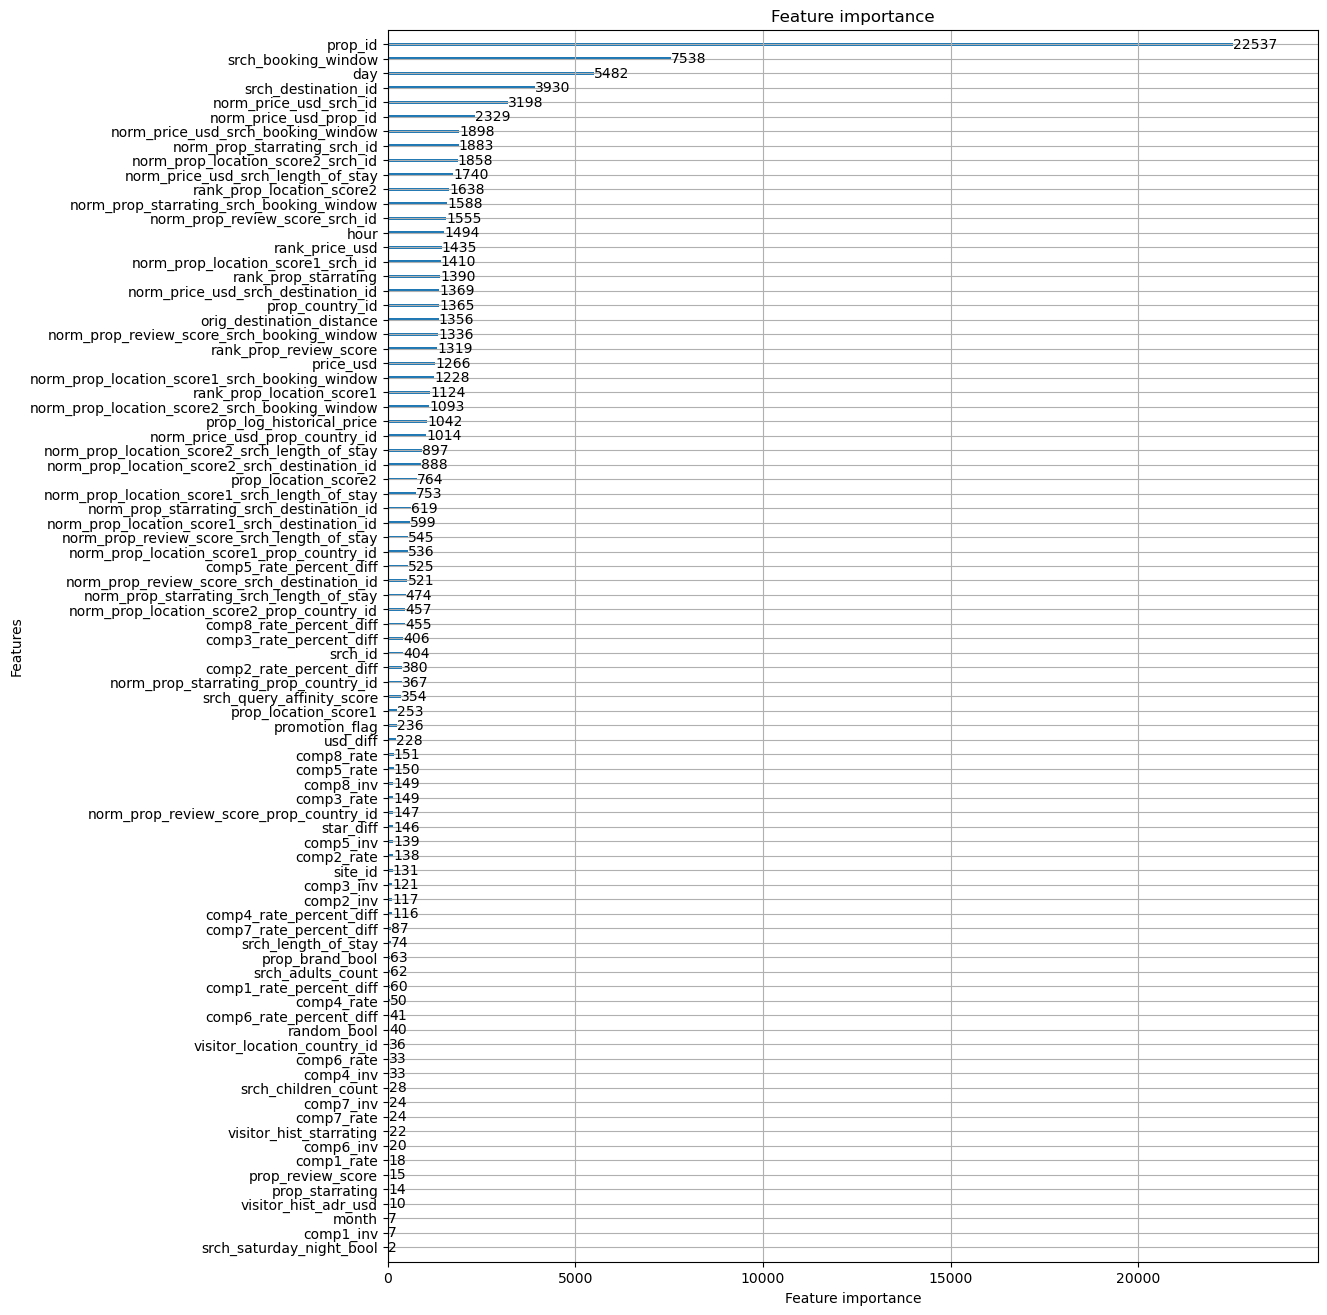

In [16]:
lgb.plot_importance(gbm, figsize = (12,16))